In [6]:
import numpy as np
import os
from PIL import Image

# Importations pour la construiction du modèle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image

# Importation pour les visualisations
import matplotlib.pyplot as plt

from keras.saving import register_keras_serializable

categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}


# couche personnalisée pour gérer le pré-traitement des images 
@register_keras_serializable()   
class EfficientnetPreprocess(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EfficientnetPreprocess, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.keras.applications.efficientnet.preprocess_input(inputs)
        
def grad_cam(image, model, layer):
    # Créer un modèle qui génère les sorties de la couche convolutive et les prédictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Calcul des gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0]).numpy() # Classe prédite
        predicted_score = tf.reduce_max(predictions[0]).numpy()
        loss = predictions[:, predicted_class]  # Perte pour la classe prédite

    # Gradients des scores par rapport aux sorties de la couche convolutive
    grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients pour chaque canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondération des activations par les gradients calculés
    conv_outputs = conv_outputs[0]  # Supprimer la dimension batch
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalisation de la carte de chaleur
    heatmap = tf.maximum(heatmap, 0)  # Se concentrer uniquement sur les valeurs positives
    heatmap /= tf.math.reduce_max(heatmap)  # Normaliser entre 0 et 1
    heatmap = heatmap.numpy()  # Convertir en tableau numpy pour la visualisation

   # Redimensionner la carte de chaleur pour correspondre à la taille de l'image d'origine
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1) # supprimer la dimension de taille 1 à la fin du tableau heatmap_resized

    # Colorier la carte de chaleur avec une palette (par exemple, "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] # Récupérer les canaux R, G, B 

    superimposed_image = heatmap_colored * 0.7 + image[0] / 255.0

    # Convertir en NumPy array et supprimer la dimension batch
    #predictions_np = predictions.numpy().squeeze() 
    
    return np.clip(superimposed_image, 0, 1), predicted_class, predicted_score

def show_grad_cam_cnn(img_files, models, class_names):

    nb_columns = len(models) + 1
    nb_lines = number_of_images = len(img_files)
    
    plt.figure(figsize=(16,16))

    for i, img_path in enumerate(img_files):
        img_array, orig = load_image(img_path)
        # affichage image originale
        subplot_index = i * nb_columns + 1
        plt.subplot(number_of_images, nb_columns, subplot_index)
        #plt.title(f'{class_names[predicted_class]} ({round_predicted_score})')
        plt.imshow(orig)
        plt.axis("off")

        for j, model in enumerate(models):
            layer = model.get_layer("top_conv")
            subplot_index += 1
            plt.subplot(number_of_images, nb_columns, subplot_index)
            # Obtenir l'image avec la carte de chaleur superposée 
            grad_cam_image, predicted_class, predicted_score = grad_cam(img_array, model, layer)
            round_predicted_score = round(float(predicted_score),2)
            # Afficher l'image avec Grad-CAM
            plt.title(f'{class_codes[predicted_class]} ({round_predicted_score})')
            plt.imshow(grad_cam_image)
            plt.axis("off")
            

    plt.show()

def load_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # Ajout d'une dimension de batch
    x = preprocess_input(x)
    return x, img






In [2]:
import tensorflow as tf
from keras.saving import register_keras_serializable
from sklearn.metrics import classification_report

# Chargement du model
models = []
models.append(tf.keras.models.load_model('../../models/EfficientNetB0/EfficientNetB0_model.keras'))
models.append(tf.keras.models.load_model("../../models/EfficientNetB0/EfficientNetB0_model_finetuned_best.keras"))


#model_loaded.summary()
#print(classification_report(y_true, y_pred, target_names=class_names))

# Check
#model_loaded.summary()
#base_model = model_loaded.get_layer("efficientnetb0")
#for layer in base_model.layers:
    #print(f"{layer.name} - trainable: {layer.trainable}")



I0000 00:00:1749299817.800544     985 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5264 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


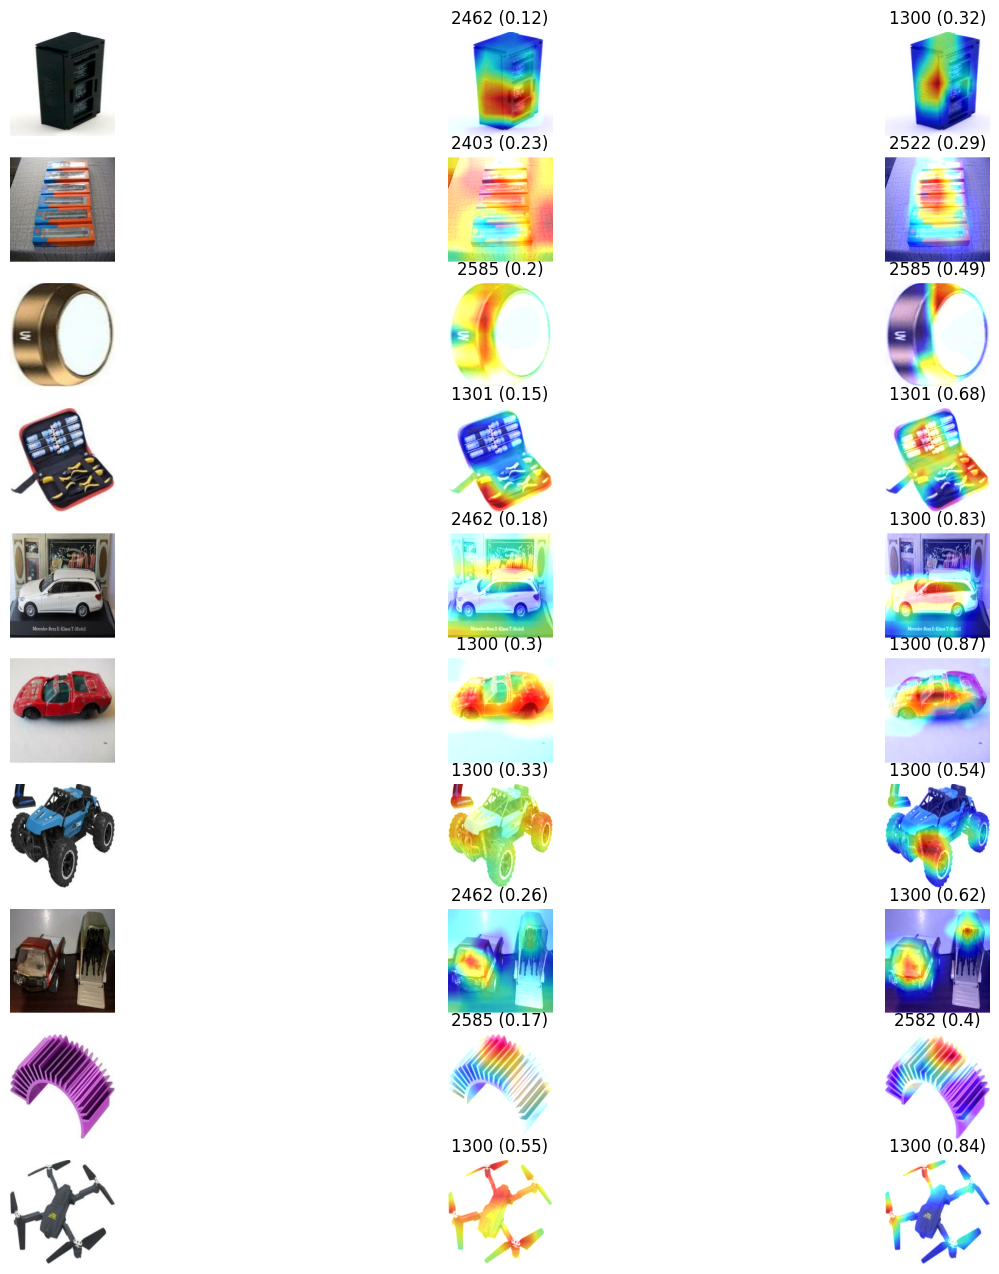

In [17]:
import os 

# Paramètres
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced" 
target_class = '1300'  # Nom de la classe que tu veux extraire
img_dir = os.path.join(dir_name, target_class)
img_size = (224, 224) # Taille cible

# Obtenir les 4 premiers fichiers image
img_file_names = sorted(os.listdir(img_dir))[:10]
class_codes = sorted(os.listdir(dir_name))
class_names = [categories[int(code)] for code in class_codes]

img_files = []
for file_name in img_file_names:
    img_files.append(os.path.join(img_dir, file_name))

show_grad_cam_cnn(img_files,models, class_codes)